# PCA-Based Fraud Detection

Credit-card companies use sophisticated machine-learning models to examine transactions in real time and identify ones that are likely to be fraudulent. The features that they use to train such models are considered proprietary, but a few sample datasets have been published that use [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) and other means to obscure the meaning behind the numbers. In this exercise, we will use [one such dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) containing anonymized information about approximately 285,000 credit-card purchases made by European cardholders in September 2013 to build an unsupervised model that uses PCA to identify fraudulent transactions.

The first step is to load the dataset.

In [1]:
import pandas as pd

df = pd.read_csv('Data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The "Time" column reveals the number of seconds elapsed since the first transaction. "Class" tells us whether the transaction is legitimate (0) or fraudulent (1), and the "Amount" column shows the amount of the transaction. The remaining columns "V1" through "V28" were generated using PCA from information that isn't revealed to us. It most likely includes information about what was purchased, where it was purchased, and who purchased it. The latter might include information such as how long the member has been a cardholder, their credit score, their spending habits, their age, and their annual income.

Find out how many rows the dataset contains and whether any of those rows having missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The dataset contains 284,807 rows, and none are missing values. Now check the balance: the number of rows representing legitimate transactions (Class=0) vs. the number of rows representing fraudulent transactions (Class=1).

In [3]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

The dataset is highly imbalanced, which isn't surprising given that legitimate credit-card transactions are far more common than fraudulent transactions. A machine-learning model trained on this data will be more accurate at identifying legitimate transactions than fraudulent transactions. That's OK, because we want to err on the side of allowing fraudulent transactions to slip through. Credit-card companies would rather let 100 fraudulent transactions go through unchallenged than bother one customer by flagging a legitimate transaction as fraudulent.

Extract the feature columns and divide the dataset into two datasets: one comprising transactions that were not fraudulent, and another comprising transactions that were.

In [4]:
# Separate the samples by class
legit = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

# Drop the "Time" and "Class" columns
legit = legit.drop(['Time', 'Class'], axis=1)
fraud = fraud.drop(['Time', 'Class'], axis=1)

Use PCA to reduce the two datasets from 29 to 26 dimensions, and then invert the transform to restore each dataset to 29 dimensions. Note that the transform is fitted to legitimate transactions only, but applied to both sets.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=26, random_state=0)
legit_pca = pd.DataFrame(pca.fit_transform(legit), index=legit.index)
fraud_pca = pd.DataFrame(pca.transform(fraud), index=fraud.index)

legit_restored = pd.DataFrame(pca.inverse_transform(legit_pca), index=legit_pca.index)
fraud_restored = pd.DataFrame(pca.inverse_transform(fraud_pca), index=fraud_pca.index)

Define a function for measuring loss due to PCA.

In [6]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

Measure the loss for both sets of transactions.

In [7]:
legit_scores = get_anomaly_scores(legit, legit_restored)
fraud_scores = get_anomaly_scores(fraud, fraud_restored)

Plot the loss for the legitimate transactions.

<AxesSubplot:>

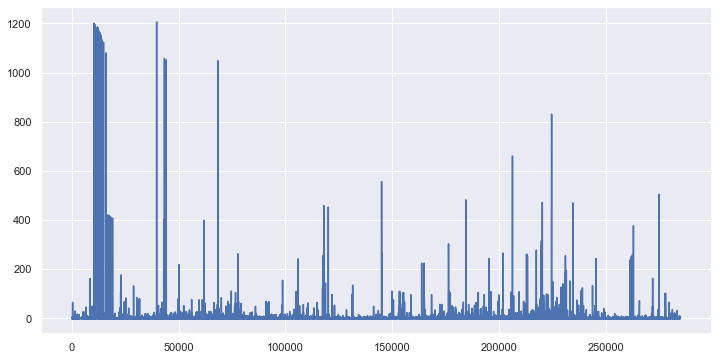

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

legit_scores.plot(figsize = (12, 6))

Plot the loss for the fraudulent transactions.

<AxesSubplot:>

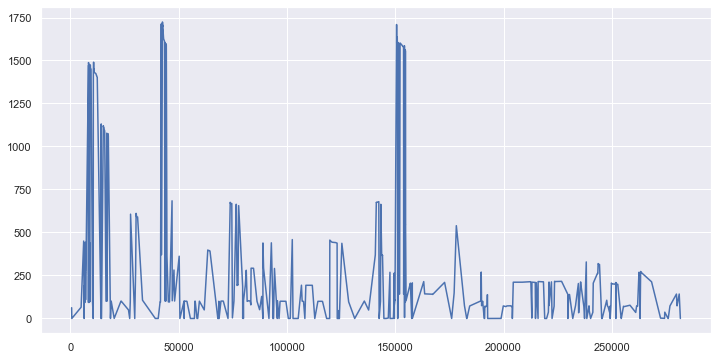

In [9]:
fraud_scores.plot(figsize = (12, 6))

Plot a confusion matrix showing how well the model identifies legitimate and fraudulent transactions with a loss threshold of 200. In other words, assume that a transaction with a loss of less than 200 is legitimate while a transaction with a loss of 200 or more is fraudulent, and see how the model performs.

Text(89.133125, 0.5, 'True label')

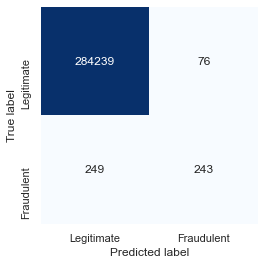

In [10]:
threshold = 200

true_neg = legit_scores[legit_scores < threshold].count()
false_pos = legit_scores[legit_scores >= threshold].count()
true_pos = fraud_scores[fraud_scores >= threshold].count()
false_neg = fraud_scores[fraud_scores < threshold].count()

labels = ['Legitimate', 'Fraudulent']
mat = [[true_neg, false_pos], [false_neg, true_pos]]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('True label')

Out of 284,315 legitimate transactions, the model correctly classified 284,239 of them as legitimate while misclassifying 76 of them as fraudulent. This means that legitimate transactions are classified correctly more than 99.97% of the time. Meanwhile, the model caught about half of the fraudulent transactions.

Unfortunately, we can't make predictions with this model because we don't know the meaning of the numbers in the "V1" through "V28" columns, and we can't generate them because we don't have the PCA transform applied to the original dataset. Nor do we know what the original dataset looked like. However, we have proved the principle that given the right features, we can build a PCA-based model that is reasonably accurate at detecting credit-card fraud.